In [125]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch

from torcheval.metrics.functional import binary_precision_recall_curve, binary_auprc
from tqdm import tqdm

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDataset
from src.deep_ad.eval import load_pretrained, pad_image
from src.deep_ad.image import plot_images, create_center_mask
from src.deep_ad.metrics import define_mse_metric, define_rmse_metric, define_psnr_metric
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.transforms import create_test_transform, normalize_to_mean_std

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
# Load configuration and save manager
config = Config(root_dir="..", config_path="../default_config.yml")
config.content_size = 24
config.stride = 16
save_manager = SaveManager(config)

Load pretrained model


In [127]:
run_name = "13-e_class_10_10_batch_pad_v3"
checkpoint_name = "epoch_100"
model = load_pretrained(config, save_manager, run_name, checkpoint_name)
model = model.to(config.device)

Checkpoint loaded from '..\save\checkpoints\13-e_class_10_10_batch_pad_v3\epoch_100.pt'.


Load the test dataset


In [128]:
test_transform = create_test_transform()
test_dataset = DAGMDataset(
    img_dir=config.DAGM_raw_dir,
    transform=test_transform,
    target_transform=test_transform,
    classes=[10],
    type="Defect-only",
    train=False,
)

Load image(s)


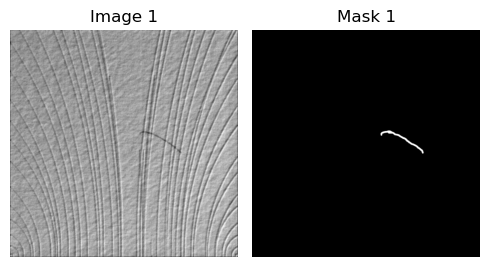

In [211]:
%matplotlib inline
from torchvision.io import read_image

idx = 1
image, image_mask = test_dataset[idx]
image_mask = test_transform(read_image("../task-3632-annotation-30-by-1-tag-Anomaly-0.png"))
image, image_mask = image.squeeze(), image_mask.squeeze()
titles = [f"Image {idx}", f"Mask {idx}"]
plot_images([image, image_mask], titles, rows=1, cols=2)

Notations:

$$
\begin{align*}
L &:=\text{image size} &=512\\
l &:=\text{patch size} &=128\\
c &:=\text{center size} &=32\\
c' &:=\text{content size} &=24\\
s &:=\text{stride} &=16\\
mp &:=\text{minimum padding} &=52\\
m &:=\text{margin} &=8\\
p &:=\text{total padding} &=60\\
\end{align*}
$$

In order to compute how much padding we need to add to each image, we must take into account several considerations.

In the first place, we want the first patch to have its content region (the center $24\times24$ region) placed on the top-leftmost pixel of the original, unpadded image. Thus, we have a _minimum padding_ ($mp$), which will be the required padding to add for the first patch to be able to reside with their center $24\times24$ regions on the $(0, 0)$ coordinates of the original image:
$$mp = \frac{l - c'}{2}$$

Second, if we slide a $24\times24$ window with stride $16$ over the original image, the last patch might require an additional margin because it won't fit. Let's call this margin $m$:
$$m = (s - ((L - c')\mod s))\mod s$$

Lastly, the total padding required, $p$, will be the sum of the minimum padding and the margin:
$$p=mp+m$$


Minimum required padding: 52
Additional margin: 8
Total padding: 60
Padded image shape: torch.Size([632, 632])
Number of windows: 32


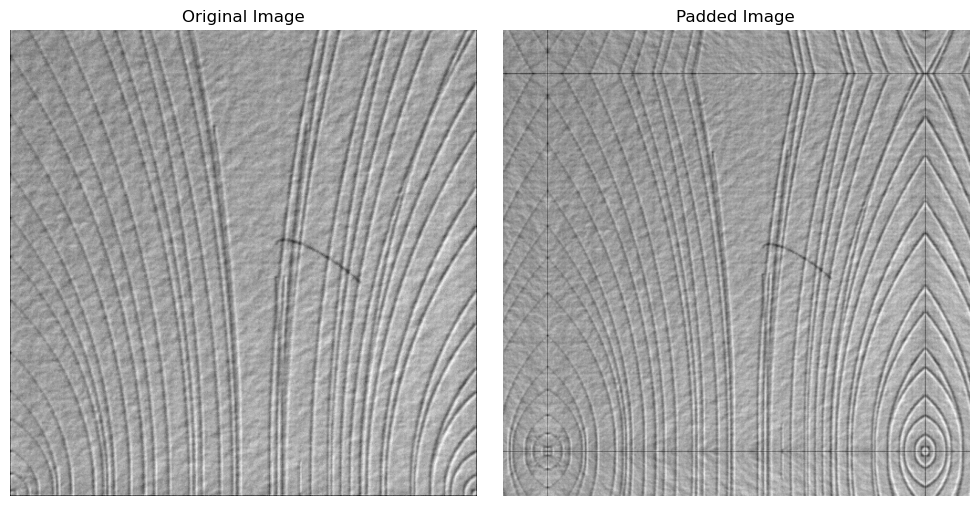

In [212]:
padded_image, min_pad, margin, pad_size = pad_image(config, image.unsqueeze(0))
image_length = image.shape[-1]
num_windows = (image_length + 2 * pad_size - config.patch_size) // config.stride + 1
print(f"Minimum required padding: {min_pad}")
print(f"Additional margin: {margin}")
print(f"Total padding: {pad_size}")
print(f"Padded image shape: {padded_image.shape}")
print(f"Number of windows: {num_windows}")
plot_images([image, padded_image], ["Original Image", "Padded Image"], rows=1, cols=2, figsize=(10, 5))

In [213]:
patches = []
inputs = []
outputs = []
titles = []
image_contents = []
inpainted_contents = []
mask = torch.asarray(create_center_mask(image_size=config.patch_size, center_size=config.center_size))
with tqdm(total=num_windows**2, desc="Patches processed", unit="patch") as pbar, torch.no_grad():
    for i in range(num_windows):
        for j in range(num_windows):
            tli, bri = margin + i * config.stride, margin + i * config.stride + config.patch_size  # top-left
            tlj, brj = margin + j * config.stride, margin + j * config.stride + config.patch_size  # bottom-right
            patch = padded_image[tli:bri, tlj:brj]
            # for patch in patches:
            input = normalize_to_mean_std(
                patch.unsqueeze(0).unsqueeze(0), mean=0.5267019737681685, std=0.19957033073362934
            )
            input = input * (1 - mask)
            input = input.to(config.device)
            output = model(input)
            output = normalize_to_mean_std(output, mean=image.mean(), std=image.std())
            tl, br = (config.patch_size - config.content_size) // 2, (config.patch_size + config.content_size) // 2
            image_contents.append(patch[tl:br, tl:br])
            inpainted_contents.append(output.detach().squeeze().cpu().numpy()[tl:br, tl:br])
            outputs.append(output.detach().squeeze().cpu().numpy())
            pbar.update(1)
inpainted_contents = torch.asarray(np.array(inpainted_contents))

Patches processed: 100%|██████████| 1024/1024 [00:08<00:00, 125.92patch/s]


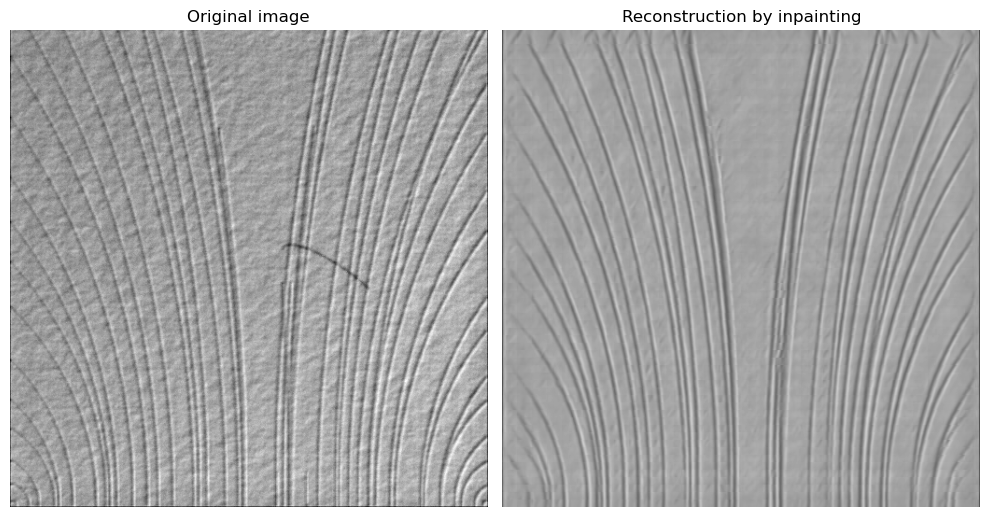

In [214]:
diffs = [torch.abs(torch.asarray(input) - torch.asarray(output)) for input, output in zip(inputs, outputs)]
content_mask = create_center_mask(128, 24)
contents = [diff * content_mask for diff in diffs]

image_size = image.shape[-1]
inpainted_image = torch.zeros((image_size + margin, image_size + margin))
weights = torch.zeros((image_size + margin, image_size + margin))
for i in range(num_windows):
    for j in range(num_windows):
        tli, bri = i * config.stride, i * config.stride + config.content_size
        tlj, brj = j * config.stride, j * config.stride + config.content_size
        inpainted_image[tli:bri, tlj:brj] += torch.asarray(inpainted_contents[i * num_windows + j])
        weights[tli:bri, tlj:brj] += 1
inpainted_image /= weights
inpainted_image = inpainted_image[:image_size, :image_size]
plot_images(
    [image, inpainted_image],
    ["Original image", "Reconstruction by inpainting"],
    rows=1,
    cols=2,
    figsize=(10, 10),
)

Best AUPRC: 0.04197739064693451 at width 0


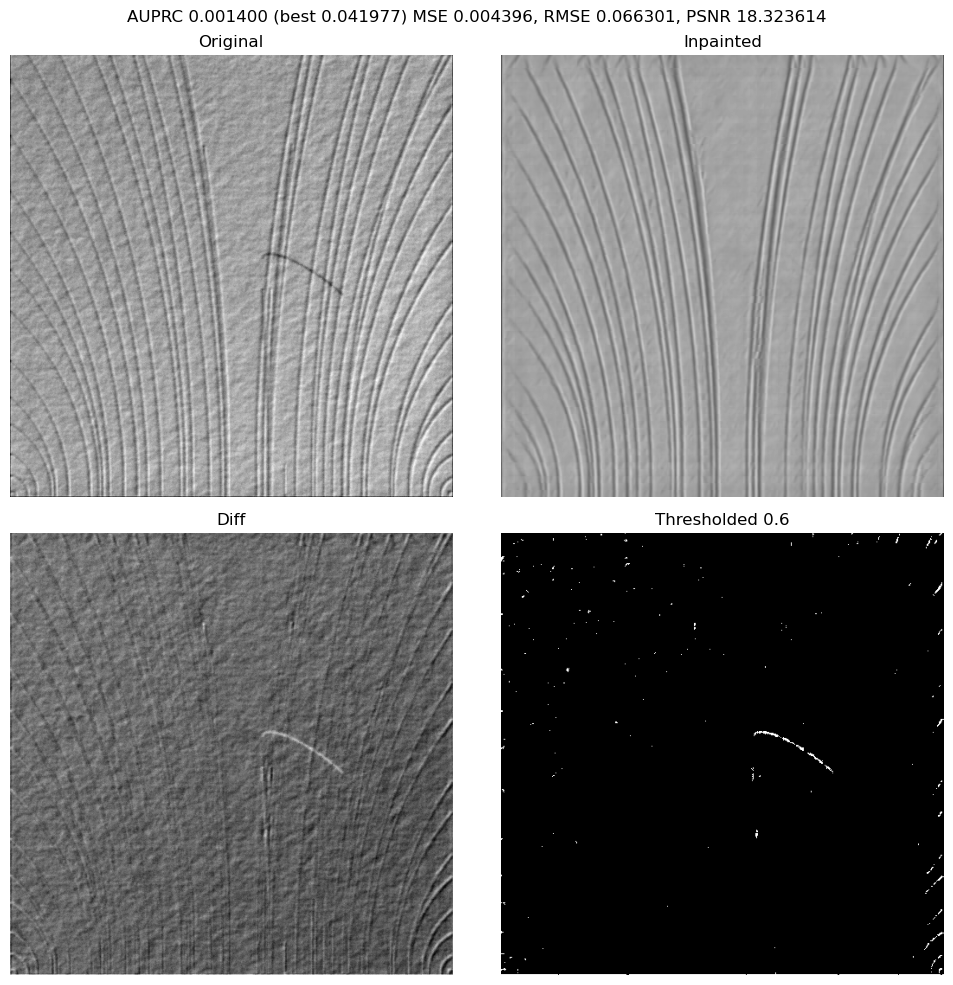

In [215]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import sigmoid

def cut_borders(image: torch.Tensor, width: int) -> torch.Tensor:
    if width > 0:
        image[:, :320] = 0
        image[:, -width:] = 0
        image[:width, :] = 0
        image[-320:, :] = 0
    return image


def postprocessing(image: torch.Tensor) -> torch.Tensor:
    weight = 1
    postproc = sigmoid(weight * ((image - image.min()) / (image.max() - image.min()) - 0.5))
    postproc = (postproc - postproc.min()) / (postproc.max() - postproc.min())
    postproc = 1 - postproc
    postproc = (postproc - postproc.min()) / (postproc.max() - postproc.min())

    return postproc

# diff_image = torch.abs(image - inpainted_image)
diff_image = postprocessing(image - inpainted_image)

# Make the borders of the diff image black (of witdth 32 pixels)
auprcs = []
best_auprc, best_width = -1, -1
lim_width = 100
for width in range(lim_width):
    diff_clone = cut_borders(diff_image.clone(), width)
    auprc = binary_auprc(diff_clone.reshape(-1), image_mask.reshape(-1))
    auprcs.append(auprc)
    if auprc > best_auprc:
        best_auprc, best_width = auprc, width

threshold = 0.6
thresholded_diff = diff_image.clone()
thresholded_diff[thresholded_diff < threshold] = 0
thresholded_diff[thresholded_diff >= threshold] = 1

mse_metric, rmse_metric, psnr_metric = define_mse_metric(), define_rmse_metric(), define_psnr_metric()
mse, rmse, psnr = (
    mse_metric(image, inpainted_image),
    rmse_metric(image, inpainted_image),
    psnr_metric(image, inpainted_image),
)


print(f"Best AUPRC: {max(auprcs)} at width {np.argmax(auprcs)}")
plot_prc = False
should_plot_images = True
if plot_prc:
    precision, recall, thresholds = binary_precision_recall_curve(diff_image.reshape(-1), image_mask.reshape(-1))
    auprc = binary_auprc(diff_image.reshape(-1), image_mask.reshape(-1))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall curve, AUPRC: {auprc}")
    plt.subplot(1, 2, 2)
    plt.plot(range(100), auprcs)
    plt.xlabel("Cutout width")
    plt.ylabel("AUPRC")
    plt.title(f"AUPRC vs. cutout width")
    plt.tight_layout()
    plt.show()    
if should_plot_images:
    plot_images(
        [image, inpainted_image, diff_image, thresholded_diff],
        ["Original", "Inpainted", "Diff", f"Thresholded {threshold}"],
        cmap="gray",
        range="01",
        rows=2,
        cols=2,
        figsize=(10, 10),
        show=False,
        title=f"AUPRC {auprc:.6f} (best {best_auprc:.6f}) MSE {mse:.6f}, RMSE {rmse:.6f}, PSNR {psnr:.6f}",
    )
    save_manager.save_plot(run_name=run_name, plot_name=f"{checkpoint_name}_eval.jpg")
    plt.show()
    plt.close()

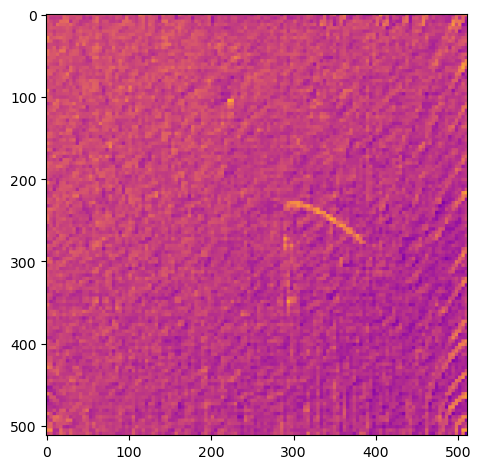

In [216]:
%matplotlib inline
from typing import Callable

def patch_metric(patch: torch.Tensor) -> float:
    return patch.max()

def compute_heatmap(image: torch.Tensor, sw_size: int, sw_stride: int, sw_num_windows: int, patch_metric: Callable[[torch.Tensor], float]) -> torch.Tensor:
    heatmap = torch.zeros_like(image)
    for row in range(sw_num_windows):
        for col in range(sw_num_windows):
            tlr, brr, tlc, brc = row * sw_stride, row * sw_stride + sw_size, col * sw_stride, col * sw_stride + sw_size
            patch = image[tlr:brr, tlc:brc]
            heatmap[tlr:brr, tlc:brc] = patch_metric(patch)
    return heatmap

def cut_margins(image: torch.Tensor, margin: int) -> torch.Tensor:
    if margin > 0:
        image[:margin, :], image[-margin:, :], image[:, :margin], image[:, -margin:] = 0, 0, 0, 0
    return image
    

sw_stride = 4
sw_size = 4
sw_num_windows = (diff_image.shape[-1] - sw_size) // sw_stride + 1
# Cut the margins
diff_cut = cut_margins(diff_image.clone(), margin=1)
heatmap = compute_heatmap(diff_cut, sw_size, sw_stride, sw_num_windows, patch_metric)
plt.imshow(heatmap, vmin=0, vmax=1, cmap='plasma')
plt.tight_layout()
plt.show()

In [217]:
%matplotlib inline
from torch.nn.functional import pad
from scipy.ndimage import label as scipy_label


def remove_islands(image: torch.Tensor, patch_size: int, plot: bool = False) -> torch.Tensor:
    """
    Args:
    * `image`: binary image
    """
    
    labeled_image, num_features = scipy_label(image.cpu().numpy())
    if num_features == 0:
        return image
    sizes = np.bincount(labeled_image.flatten())
    sizes[0] = 0 # Background denoted by 0
    sorted_islands = np.argsort(sizes)
    biggest_island = sizes[sorted_islands[-1]]
    keep_labels = sorted_islands[sizes[sorted_islands] >= int(biggest_island * 0.7)]
    print(keep_labels)
    mask = torch.zeros_like(image)
    for label in keep_labels:
        mask = torch.logical_or(mask, torch.asarray(labeled_image == label))
    # for label in keep_labels:
    #     labeled_image[labeled_image != sorted_islands[-1]] = 0
    #     labeled_image[labeled_image == sorted_islands[-1]] = 1
    return image * mask
    print(sorted_islands)
    print(num_features)
    print(labeled_image)
    plot_images([labeled_image], ["Labeled"], cmap='hot', range="minmax")
    # left = pad(image, (0, patch_size, 0, 0))[:, patch_size:]
    # right = pad(image, (patch_size, 0, 0, 0))[:, :-patch_size]
    # up = pad(image, (0, 0, 0, patch_size))[patch_size:, :]
    # down = pad(image, (0, 0, patch_size, 0))[:-patch_size, :]
    # combined = image + left + right + up + down
    # combined[combined <= 1] = 0
    # combined[combined > 1] = 1
    # if plot:
    #     plot_images([left, right, up, down, image * combined], ["Left", "Right", "Up", "Down", "Combined"], rows=3, cols=2, figsize=(6, 9))
    # return image * combined

threshold = 0.54
hmc = heatmap.clone()
hmc[hmc < threshold], hmc[hmc >= threshold] = 0, 1
remove_islands(hmc, patch_size=sw_stride, plot=True)

[424]


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
%matplotlib tk
from matplotlib.widgets import Slider


def apply_transforms(image: torch.Tensor, threshold: float, width: int) -> torch.Tensor:
    hmc = heatmap.clone()
    hmc[hmc < threshold] = 0
    hmc[hmc >= threshold] = 1
    hmc = remove_islands(hmc, patch_size=sw_stride)
    if width > 0:
        image[:width, :] = 0
        image[-width:, :] = 0
        image[:, :width] = 0
        image[:, -width:] = 0
    image = image * hmc
    return image

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(bottom=0.25)

threshold = 0.625
slider_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])
slider_threshold = Slider(slider_ax, "Threshold", 0, 1, valinit=threshold, valstep=0.001)

width = 0
slider_width = Slider(fig.add_axes([0.2, 0.15, 0.6, 0.03]), "Width", 0, 100, valinit=width, valstep=1)

initial_image = apply_transforms(diff_image.clone(), threshold, width)
im = axs.imshow(initial_image, vmin=0, vmax=1, cmap='gray')
im_title = fig.suptitle(f"AUPRC: {binary_auprc(initial_image.reshape(-1), image_mask.reshape(-1))}")

def update_plot(new_image: torch.Tensor) -> None:
    global im, im_title, fig
    im.set_data(new_image)
    im_title.set_text(f"AUPRC: {binary_auprc(new_image.reshape(-1), image_mask.reshape(-1))}")
    fig.canvas.draw_idle()

def update_threshold(val: float) -> None:
    global threshold, width
    threshold = val
    diff_thresholded = apply_transforms(diff_image.clone(), threshold, width)
    update_plot(diff_thresholded)

def update_width(val: float) -> None:
    global width
    width = int(val)
    diff_thresholded = apply_transforms(diff_image.clone(), threshold, width)
    update_plot(diff_thresholded)

slider_threshold.on_changed(update_threshold)
slider_width.on_changed(update_width)
plt.show()

[52]


[49]
[52]
[53]
[58]
[68]
[77]
[79]
[89]
[94]
[105]
[119]
[122]
[135]
[150]
[151]
[183]
[216]
[230]
[240]
[250]
[265]
[278]
[290]
[325]
[346]
[357]
[373]
[384]
[403]
[414]
[422]
[422]
[418]
[421]
[424]
[428]
[432]
[437]
[449]
[  2 450]
[  2 452]
[  2 455]
[ 41   2 455]
[  2 455]
[  2 452]
[  2 450]
[449]
[437]
[432]
[428]
[424]
[421]
[418]
[422]
[422]
[414]
[403]
[384]
[383]
[373]
[357]
[346]
[325]
[308]
[302]
[290]
[278]
[265]
[278]
[290]
[308]
[325]
[346]
[383]
[384]
[403]
[414]
[422]
[418]
[421]
[424]
[428]
[432]
[437]
[449]
[  2 450]
[  2 452]
[  2 455]
[  2 452]
[  2 450]
[449]
[437]
[432]
[428]
[421]
[418]
[422]
[422]
[414]
[384]
[383]
[357]
[346]
[325]
[308]
[302]
[308]
[325]
[346]
[357]


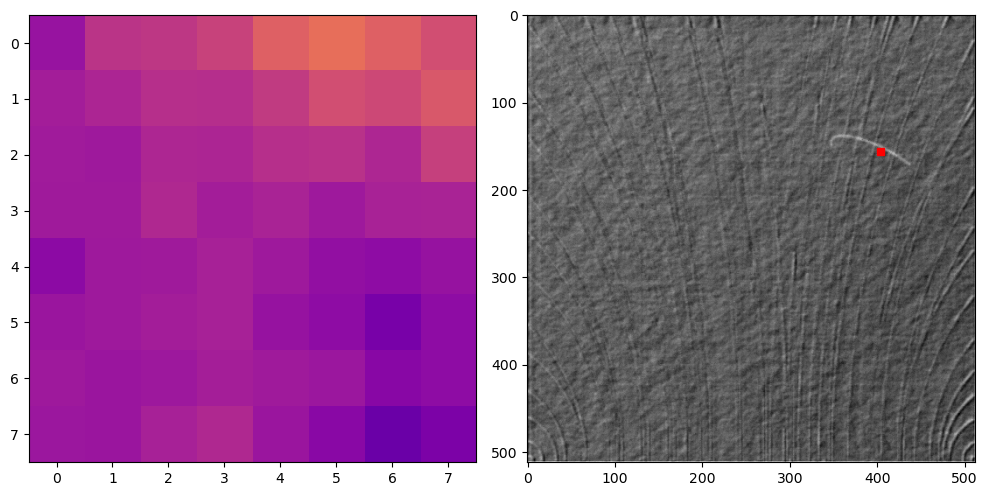

In [91]:
%matplotlib inline
import matplotlib.patches as mpl_patches

sw_stride = 8
sw_size = 8
sw_num_windows = (diff_image.shape[-1] - sw_size) // sw_stride + 1

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
row, col = 19, 50
plt.imshow(diff_patches[row * sw_num_windows + col], vmin=0, vmax=1, cmap="plasma")

ax = plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(diff_image.numpy(), cv.COLOR_GRAY2RGB))
rect = mpl_patches.Rectangle((col * sw_stride, row * sw_stride), sw_size, sw_size, facecolor='red', edgecolor='red', alpha=1)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [97]:
lim = 10
print(precision[:lim])
print(recall[:lim])
print(thresholds[:lim])

tensor([0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0.0000, 0.0071, 0.0079, 0.0339, 0.0341, 0.0351, 0.0363, 0.0370, 0.0421,
        0.0428])


In [20]:
mse_metric = define_mse_metric()
mse = mse_metric(image, inpainted_image)
print(f"MSE: {mse}")
my_mse = torch.sum((image - inpainted_image) ** 2) / (image.shape[-1] * image.shape[-2])
print(f"My MSE: {my_mse}")
print(f"MSE == My MSE?: {mse == my_mse}")

rmse_metric = define_rmse_metric()
rmse = rmse_metric(image, inpainted_image)
print(f"RMSE: {rmse}")
my_rmse = torch.sqrt(my_mse)
print(f"My RMSE: {my_rmse}")
print(f"RMSE == My RMSE?: {rmse == my_rmse}")

psnr_metric = define_psnr_metric()
psnr = psnr_metric(inpainted_image, image)
print(f"PSNR: {psnr}")
my_psnr = 20 * torch.log10(torch.max(image)) - 10 * torch.log10(my_mse)
print(f"My PSNR: {my_psnr}")
print(f"PSNR ==(close) My PSNR?: {torch.allclose(psnr, my_psnr)}")

MSE: 0.005090771708637476
My MSE: 0.005090771708637476
MSE == My MSE?: True
RMSE: 0.07134964317083359
My RMSE: 0.07134964317083359
RMSE == My RMSE?: True
PSNR: 22.898035049438477
My PSNR: 22.89803695678711
PSNR ==(close) My PSNR?: True
